## Preparations: packages, data, defining CV and performance matrics

In [78]:
# Package imports
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns

In [79]:
# Load & sample data
# sklearn automatically converts strings to integer entries 
# Fine with categorical entries for LDA & QDA
# Replace with your local path
data1 = pd.read_csv('/Users/guqian/Desktop/LSE/ST443/project/ml_project/data/data1.csv', low_memory=False)

In [80]:
# feature columns
bands = [col for col in data1.columns if col.startswith("B")]
pixels = ["p_x","p_y"]
feature_cols = bands + pixels

# Successing from task 1.1, we cap reflectance values to [0, 1]
data1[bands] = data1[bands].clip(lower=0, upper=1)
print("After clipping:")
print("Min reflectance:", data1[bands].min().min())
print("Max reflectance:", data1[bands].max().max())

After clipping:
Min reflectance: 0.0
Max reflectance: 1.0


In [81]:
# Drop missing labels and optionally sample
data1 = data1.dropna(subset=["land_type"])
X = data1[feature_cols].to_numpy(dtype=np.float32)
y = data1["land_type"].to_numpy()
classes = np.unique(y)

In [82]:
# Split full data into 80% training, 20% final test (never touched during CV)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    stratify=y, # Ensures rare classes don’t accidentally disappear from the test set
    random_state=42
)
print(X_train.shape, X_test.shape) # Train/test dimensions

(172483, 220) (43121, 220)


In [83]:
# Define fold number=5
def evaluate_cv(pipe, X, y, n_splits=5, random_state=42):
    # Define how CV will be done
    # StratifiedKFold ensures each fold to have at least samples from each class, under inbalanced class distribution
    skf_LQDA = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    y_true_all, y_pred_all, y_prob_all = [], [], []
    # Run the cross-validation loop
    for tr, va in skf_LQDA.split(X, y):
        Xtr, Xva = X[tr], X[va]
        ytr, yva = y[tr], y[va]

        pipe.fit(Xtr, ytr)
        y_pred = pipe.predict(Xva)
        # Store predictions
        y_true_all.append(yva)
        y_pred_all.append(y_pred)
        y_prob_all.append(pipe.predict_proba(Xva))

    # Combine results from all folds
    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)
    y_prob = np.vstack(y_prob_all)

    # Define performance metrics with in-built functions from sklearn
    y_bin = label_binarize(y_true, classes=classes)
    return {
        "acc": accuracy_score(y_true, y_pred), 
        "bal_acc": balanced_accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"), # macro: compute the metric separately for each class then average (for inbalanced class distribution)
        "auc_macro": roc_auc_score(y_bin, y_prob, average="macro", multi_class="ovr"),
        "cm": confusion_matrix(y_true, y_pred, labels=classes)
    }

In [84]:
# Define confusion matrix set up
def plot_confusion_matrix(y_true, y_pred, class_names, normalize, model_name):
    fig = plt.figure(figsize=(12, 12), dpi=100)
    ax = fig.add_subplot(111)
    ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=class_names,
        normalize=normalize,
        cmap="Blues",
        colorbar=True,
        ax=ax
    )
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.tight_layout()
    plt.show()

## LDA
5 fold cross validation
80% data for cv, 20% data for testing and performance matrics

In [85]:
# Define LDA pipelines: one raw (full data), one with PCA10
lda_raw = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LinearDiscriminantAnalysis())
])

lda_pca10 = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=10, random_state=42)),
    ("clf", LinearDiscriminantAnalysis())
])

In [86]:
# Fit LDA on the 80% training set
lda_raw.fit(X_train, y_train)
lda_pca10.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=10, random_state=42)),
                ('clf', LinearDiscriminantAnalysis())])

In [87]:
# LDA predictions on the 20% test set
lda20_pred_raw = lda_raw.predict(X_test)
lda20_prob_raw = lda_raw.predict_proba(X_test) # Predicted class probabilities for each test sample (needed for AUC).

lda20_pred_pca = lda_pca10.predict(X_test)
lda20_prob_pca = lda_pca10.predict_proba(X_test)

In [88]:
# LDA performance metrics
# Binarise test labels for multi-class AUC
y_test_bin = label_binarize(y_test, classes=classes)

# Metrics on test set – LDA raw
lda_test_raw = { # lda(qda)_test_raw(pca) is just defined for performance metric storage
    "acc": accuracy_score(y_test, lda20_pred_raw),
    "bal_acc": balanced_accuracy_score(y_test, lda20_pred_raw),
    "f1_macro": f1_score(y_test, lda20_pred_raw, average="macro"),
    "auc_macro": roc_auc_score(
        y_test_bin, lda20_prob_raw, average="macro", multi_class="ovr"
    ),
    "cm": confusion_matrix(y_test, lda20_pred_raw, labels=classes),
}

# Metrics on test set – LDA with PCA(10)
lda_test_pca = {
    "acc": accuracy_score(y_test, lda20_pred_pca),
    "bal_acc": balanced_accuracy_score(y_test, lda20_pred_pca),
    "f1_macro": f1_score(y_test, lda20_pred_pca, average="macro"),
    "auc_macro": roc_auc_score(
        y_test_bin, lda20_prob_pca, average="macro", multi_class="ovr"
    ),
    "cm": confusion_matrix(y_test, lda20_pred_pca, labels=classes),
}

In [89]:
# Summary table from test metrics (LDA)
summary_lda_test = pd.DataFrame([
    {
        "Model": "LDA (raw)",
        "Accuracy": lda_test_raw["acc"],
        "Balanced Acc": lda_test_raw["bal_acc"],
        "AUC (macro-ovr)": lda_test_raw["auc_macro"],
        "F1 (macro)": lda_test_raw["f1_macro"],
    },
    {
        "Model": "LDA (PCA10)",
        "Accuracy": lda_test_pca["acc"],
        "Balanced Acc": lda_test_pca["bal_acc"],
        "AUC (macro-ovr)": lda_test_pca["auc_macro"],
        "F1 (macro)": lda_test_pca["f1_macro"],
    },
])

display(summary_lda_test.round(4))

,Model,Accuracy,Balanced Acc,AUC (macro-ovr),F1 (macro)
0,LDA (raw),0.8615,0.8601,0.9908,0.8621
1,LDA (PCA10),0.8406,0.8331,0.9885,0.8384


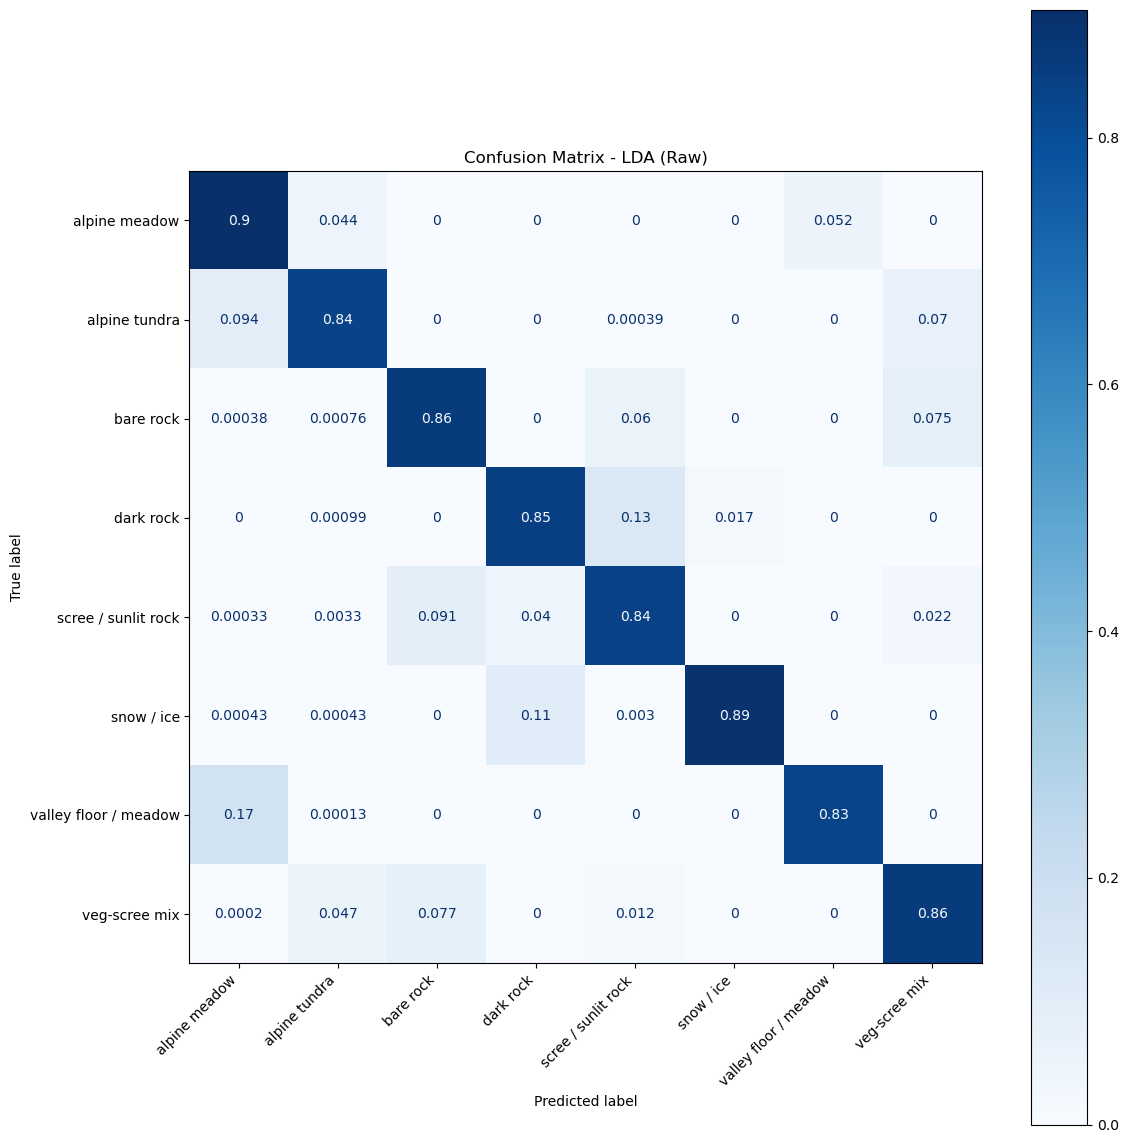

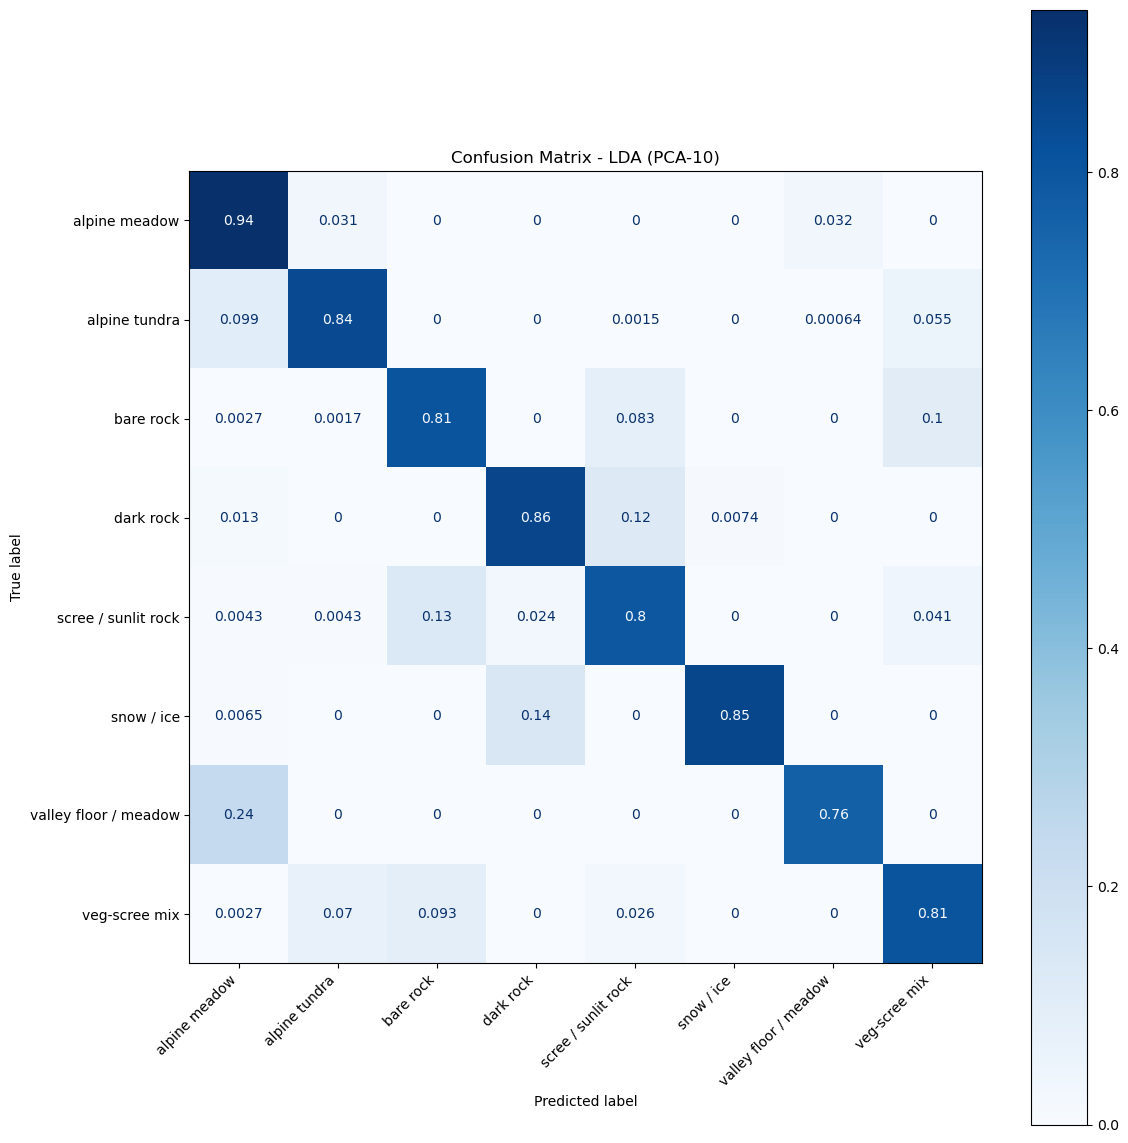

In [90]:
# Confusion matrices on test set (LDA)
plot_confusion_matrix(
    y_true=y_test,
    y_pred=lda20_pred_raw,
    class_names=classes,
    normalize="true",
    model_name="LDA (Raw)"
)

plot_confusion_matrix(
    y_true=y_test,
    y_pred=lda20_pred_pca,
    class_names=classes,
    normalize="true",
    model_name="LDA (PCA-10)"
)

## QDA
5 fold cross validation
80% data for cv, 20% data for testing and performance matrics

In [91]:
# Define QDA pipelines: one raw (full data), one with PCA10
qda_raw = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", QuadraticDiscriminantAnalysis())
])

qda_pca10 = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=10, random_state=42)),
    ("clf", QuadraticDiscriminantAnalysis())
])

In [92]:
# Helper: fit QDA, fall back to regularised version if needed (QDA unstable for high-dimensional data)
def fit_qda_maybe_reg(pipe, X_train, y_train, reg_param=0.1):
    try:
        pipe.fit(X_train, y_train)
        return pipe
    except Exception:
        # If covariance is singular, use a small regularisation
        pipe_reg = Pipeline(
            pipe.steps[:-1] + [("clf", QuadraticDiscriminantAnalysis(reg_param=reg_param))]
        )
        pipe_reg.fit(X_train, y_train)
        return pipe_reg

# Fit QDA models on the 80% training set with the helper
qda80_raw = fit_qda_maybe_reg(qda_raw, X_train, y_train)
qda80_pca10 = fit_qda_maybe_reg(qda_pca10, X_train, y_train)

In [93]:
# QDA performance metrics
# Predictions on the 20% test set
qda20_pred_raw = qda80_raw.predict(X_test)
qda20_prob_raw = qda80_raw.predict_proba(X_test)

qda20_pred_pca = qda80_pca10.predict(X_test)
qda20_prob_pca = qda80_pca10.predict_proba(X_test)

# Binarise test labels for AUC
y_test_bin = label_binarize(y_test, classes=classes)

# Metrics on test set – QDA raw
qda_test_raw = {
    "acc": accuracy_score(y_test, qda20_pred_raw),
    "bal_acc": balanced_accuracy_score(y_test, qda20_pred_raw),
    "f1_macro": f1_score(y_test, qda20_pred_raw, average="macro"),
    "auc_macro": roc_auc_score(
        y_test_bin, qda20_prob_raw, average="macro", multi_class="ovr"
    ),
    "cm": confusion_matrix(y_test, qda20_pred_raw, labels=classes),
}

# Metrics on test set – QDA with PCA(10)
qda_test_pca = {
    "acc": accuracy_score(y_test, qda20_pred_pca),
    "bal_acc": balanced_accuracy_score(y_test, qda20_pred_pca),
    "f1_macro": f1_score(y_test, qda20_pred_pca, average="macro"),
    "auc_macro": roc_auc_score(
        y_test_bin, qda20_prob_pca, average="macro", multi_class="ovr"
    ),
    "cm": confusion_matrix(y_test, qda20_pred_pca, labels=classes),
}

In [94]:
# Summary table from test metrics (QDA)
summary_qda_test = pd.DataFrame([
    {
        "Model": "QDA (raw)",
        "Accuracy": qda_test_raw["acc"],
        "Balanced Acc": qda_test_raw["bal_acc"],
        "AUC (macro-ovr)": qda_test_raw["auc_macro"],
        "F1 (macro)": qda_test_raw["f1_macro"],
    },
    {
        "Model": "QDA (PCA10)",
        "Accuracy": qda_test_pca["acc"],
        "Balanced Acc": qda_test_pca["bal_acc"],
        "AUC (macro-ovr)": qda_test_pca["auc_macro"],
        "F1 (macro)": qda_test_pca["f1_macro"],
    },
])

display(summary_qda_test.round(4))

,Model,Accuracy,Balanced Acc,AUC (macro-ovr),F1 (macro)
0,QDA (raw),0.8392,0.8428,0.9848,0.8393
1,QDA (PCA10),0.9167,0.9168,0.9949,0.9158


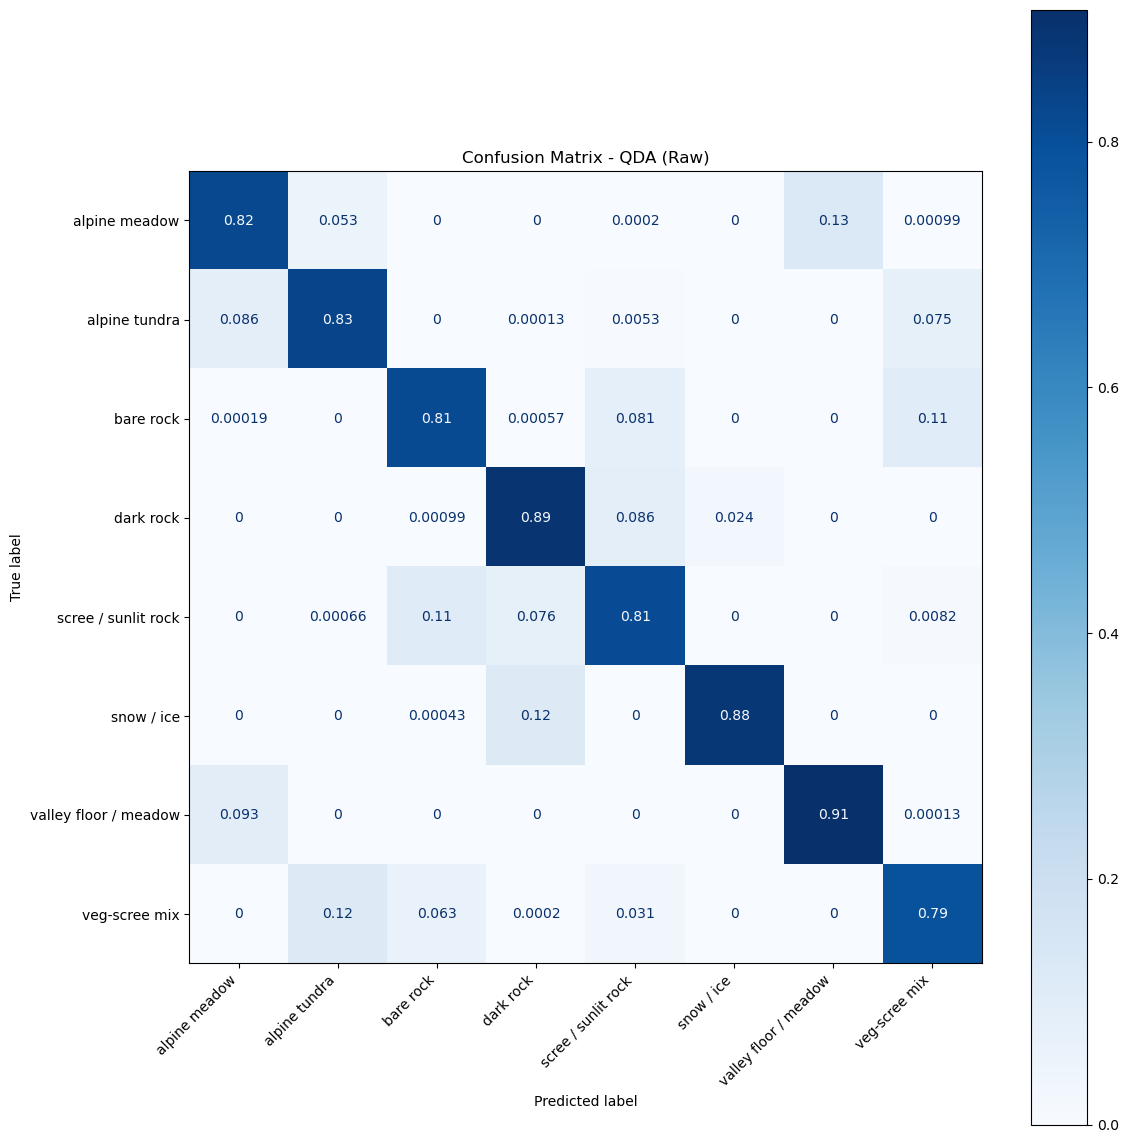

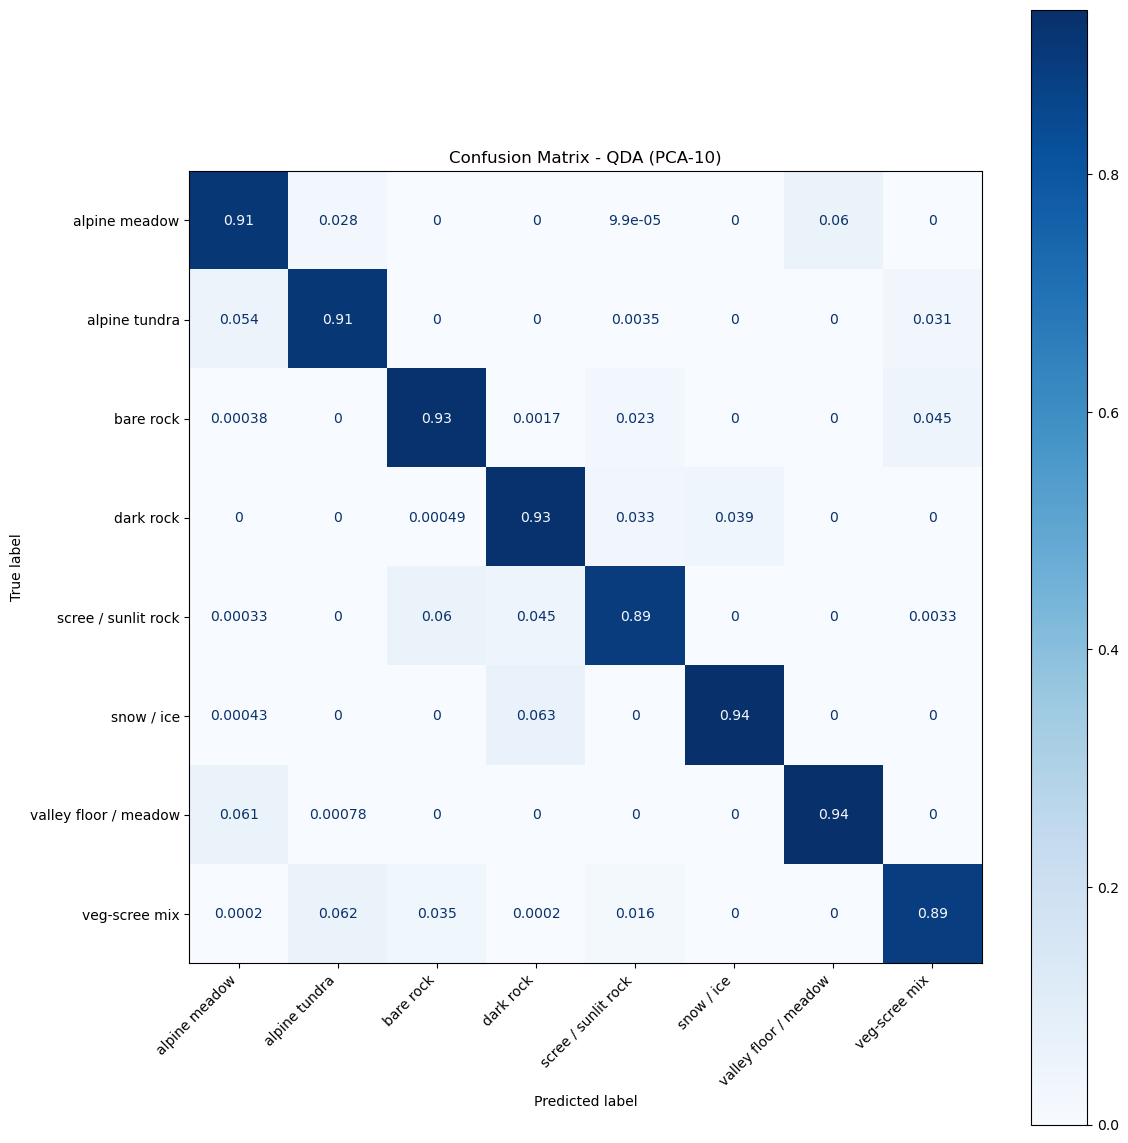

In [95]:
# Confusion matrices on test set (QDA)
plot_confusion_matrix(
    y_true=y_test,
    y_pred=qda20_pred_raw,
    class_names=classes,
    normalize="true",
    model_name="QDA (Raw)"
)

plot_confusion_matrix(
    y_true=y_test,
    y_pred=qda20_pred_pca,
    class_names=classes,
    normalize="true",
    model_name="QDA (PCA-10)"
)

# Combined comparison for easy reading

In [96]:
summary_all = pd.concat([summary_lda_test, summary_qda_test], ignore_index=True)
display(summary_all)

,Model,Accuracy,Balanced Acc,AUC (macro-ovr),F1 (macro)
0,LDA (raw),0.861483,0.860111,0.990794,0.862057
1,LDA (PCA10),0.840588,0.833129,0.988525,0.838366
2,QDA (raw),0.839197,0.842769,0.984779,0.839298
3,QDA (PCA10),0.916653,0.916828,0.994898,0.915836
